# Recommendation System Project
##### [1. Word Cloud Generation with "지원동기"](#1.-Word-Cloud-Generation)
##### [2. Topic Modeling to extract values](#2.-Topic-Modeling)
##### [3. FFM Prediction](#3.-FFM)

## 1. Word Cloud Generation

page_1_to_10.csv's valid motivs: 88 out of 96
total valid reasons: 88


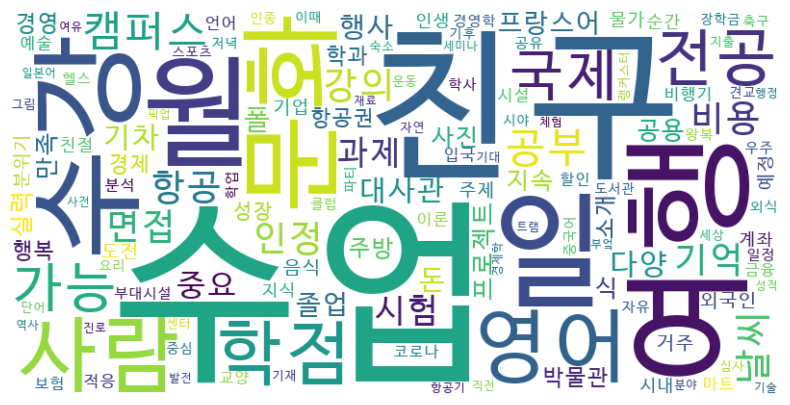

In [ ]:
from utils.extract_helper import *
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
from konlpy.tag import Mecab
import os

path_to_files = "data_set"
files_to_process = ["page_1_to_10.csv", "page_11_to_22.csv", "page_23_to_100.csv", "page_101_to_200.csv", "page_201_to_300.csv", "page_301_to_376.csv"]

# 임시!!!!!!!!!
files_to_process = ["page_1_to_10.csv"]


# 불용어 처리
stopwords = set()
with open("stopwords.txt", 'r', encoding='utf-8') as file:
    for line in file:
        words = line.split()  # 기본적으로 공백을 기준으로 split
        stopwords.update(words)  # set에 words 추가 (중복 제거)

# 각 파일에서 '지원 동기'에 해당하는 부분 parse
mecab = Mecab()                     # mecab 형태소 분석기 생성
cleaned_text = ""                   # 워드 클라우드에 들어갈 긴 string
total_motiv_cnt = 0                 # 유효한 지원동기 개수

# topic modeling, ffm에 사용될 df
df_features = pd.DataFrame()

for file_name in files_to_process:
    file_path = os.path.join(path_to_files, file_name)
    df = pd.read_csv(file_path)
    
    # csv 파일 내용 parse
    df['Selected Content'] = df.apply(select_content, axis=1)
    df['Processed Content'] = df.apply(process_content, axis=1)
    df['Processed Content'] = df['Processed Content'].apply(lambda x : preprocess_text(x, stopwords, mecab))
    tot_len = len(df['Processed Content'])

    motivs = df['Processed Content'].dropna() # NAN 제거
    motivs = motivs[motivs.str.strip() != ""]  # 빈 문자열 제거

    print(f"{file_name}'s valid motivs: {len(motivs)} out of {tot_len}")
    total_motiv_cnt += len(motivs)

    df_features = pd.concat([df_features, df[['Year', 'Semester', 'Country', 'School', 'Student_number', 'Department', 'Processed Content']]])

    # 텍스트 전처리
    text = ' '.join(motivs)  # 모든 텍스트를 결합

    # 명사 리스트를 하나의 문자열로 변환
    cleaned_text += ' ' + text

print(f"total valid reasons: {total_motiv_cnt}")

# WordCloud 객체 생성
cleaned_text = cleaned_text.split()
cleaned_text_cnt = Counter(cleaned_text)
min_freq = 10
cleaned_text_flt = {word: count for word, count in cleaned_text_cnt.items() if count >= min_freq}

font_path = "/Users/gayeonlee/Library/Fonts/D2Coding-Ver1.3.2-20180524.ttc"
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=font_path).generate_from_frequencies(cleaned_text_flt)

# 워드 클라우드 표시
plt.figure(figsize=(10, 5))
plt.rc('font', family='AppleGothic')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 축 제거
plt.show()

## 2. Topic Modeling

Try find the "optimal" number of topics

Number of Topics: 2, Perplexity: 558.0383546026778
Number of Topics: 3, Perplexity: 559.131434202571
Number of Topics: 4, Perplexity: 548.0654255496473
Number of Topics: 5, Perplexity: 591.0400343312427
Number of Topics: 6, Perplexity: 586.2123475633751
Number of Topics: 7, Perplexity: 606.8873823734708
Number of Topics: 8, Perplexity: 601.4718067988553
Number of Topics: 9, Perplexity: 610.945142076203
Number of Topics: 10, Perplexity: 600.6953428969861
Number of Topics: 11, Perplexity: 604.4964989548051
Number of Topics: 12, Perplexity: 633.1679488605157
Number of Topics: 13, Perplexity: 612.3688001121244
Number of Topics: 14, Perplexity: 619.1834584159805
Number of Topics: 15, Perplexity: 636.9145254436962
Number of Topics: 16, Perplexity: 636.3268563832827
Number of Topics: 17, Perplexity: 647.4343006155948
Number of Topics: 18, Perplexity: 628.5573480735166
Number of Topics: 19, Perplexity: 655.6356530779711
Number of Topics: 20, Perplexity: 680.9058225847904
Number of Topics: 21, 

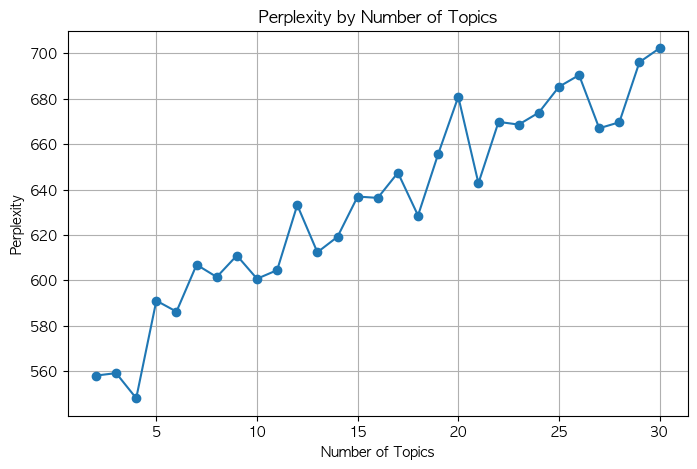

In [2]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# 지원 동기 부분만 추출해서 사용
total_motivs = df_features['Processed Content'].reset_index(drop=True)

# 문서-단어 행렬 생성
vectorizer = CountVectorizer(max_features=1000)
X = vectorizer.fit_transform(total_motivs)

# 토픽 수별 Perplexity 계산
max_topics = 30
perplexities = []

for num_topics in range(2, max_topics + 1):
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(X)
    perplexity = lda.perplexity(X)
    perplexities.append(perplexity)
    print(f"Number of Topics: {num_topics}, Perplexity: {perplexity}")

# Perplexity 시각화
plt.figure(figsize=(8, 5))
plt.plot(range(2, max_topics + 1), perplexities, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity")
plt.title("Perplexity by Number of Topics")
plt.grid()
plt.show()

In [11]:
import pyLDAvis

# 위에 결과에서 '최적'의 토픽 수 선정
optimal_topic_number = 3

# 빈 거 드랍
valid_motivs = df_features['Processed Content'].dropna()
valid_motivs = valid_motivs[valid_motivs.str.strip() != ""]  # 빈 문자열 제거
valid_motivs = valid_motivs.reset_index(drop=True)  # 인덱스 재설정

# LDA 모델 학습
num_topics = optimal_topic_number  # 주제 수
X = vectorizer.fit_transform(valid_motivs)

lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

# 주제별 상위 단어 출력
terms = vectorizer.get_feature_names_out()

for idx, topic in enumerate(lda.components_):
    print(f"\n주제 {idx + 1}:")
    print([terms[i] for i in topic.argsort()[:-11:-1]])

# 문서별 주제 분포 출력
doc_topics = lda.transform(X)
doc_topic_df = pd.DataFrame(doc_topics, columns=[f"주제 {i + 1}" for i in range(num_topics)])
doc_topic_df['Value'] = doc_topic_df.idxmax(axis=1)
doc_topic_df['Value'] = doc_topic_df['Value'].str.replace('주제 ', '').astype(int)
doc_topic_df['Processed Content'] = valid_motivs

# 데이터에 value 항목 추가
df_features = df_features.merge(doc_topic_df[['Processed Content', 'Value']], on='Processed Content', how='left')
df_features.to_csv('output.csv', index=False, header=True, encoding='utf-8-sig')


# 문서-단어 행렬과 LDA 모델 결과를 시각화에 맞게 변환
lda_vis_data = pyLDAvis.prepare(
    topic_term_dists=lda.components_,          # LDA 주제-단어 분포
    doc_topic_dists=lda.transform(X),         # 문서-주제 분포
    doc_lengths=X.sum(axis=1).A1,             # 각 문서의 단어 수
    vocab=vectorizer.get_feature_names_out(), # 단어 목록
    term_frequency=X.sum(axis=0).A1          # 전체 단어 빈도
)

# 시각화 출력
pyLDAvis.display(lda_vis_data)
pyLDAvis.save_html(lda_vis_data, f'lda_visualization/lda_visualization_temp_{optimal_topic_number}.html')


주제 1:
['수업', '친구', '여행', '수강', '영어', '문화', '전공', '항공', '박물관', '캠퍼스']

주제 2:
['수업', '학점', '인정', '친구', '면접', '가능', '프로젝트', '수강', '여행', '지속']

주제 3:
['수업', '친구', '여행', '사람', '수강', '국제', '문화', '영어', '기억', '공부']
